In [ ]:


# @title import Libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import datetime  # Import the datetime module

import warnings
warnings.filterwarnings("ignore")

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:

color_palette = sns.color_palette("plasma")
sns.set_palette(color_palette)


In [ ]:
# @title 1.Data Collection

df = pd.read_csv("/content/sentimentdataset.csv")#load csv file
df.head().style.background_gradient(cmap='plasma')


,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park!,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.000000,30.000000,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning.,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.000000,10.000000,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.000000,40.000000,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway!,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.000000,15.000000,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight.,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.000000,25.000000,Australia,2023,1,15,19


In [ ]:
df.describe().style.background_gradient(cmap='tab20c')


,Unnamed: 0.1,Unnamed: 0,Retweets,Likes,Year,Month,Day,Hour
count,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000
mean,366.464481,369.740437,21.508197,42.901639,2020.471311,6.122951,15.497268,15.521858
std,211.513936,212.428936,7.061286,14.089848,2.802285,3.411763,8.474553,4.113414
min,0.000000,0.000000,5.000000,10.000000,2010.000000,1.000000,1.000000,0.000000
25%,183.750000,185.750000,17.750000,34.750000,2019.000000,3.000000,9.000000,13.000000
50%,366.500000,370.500000,22.000000,43.000000,2021.000000,6.000000,15.000000,16.000000
75%,549.250000,553.250000,25.000000,50.000000,2023.000000,9.000000,22.000000,19.000000
max,732.000000,736.000000,40.000000,80.000000,2023.000000,12.000000,31.000000,23.000000


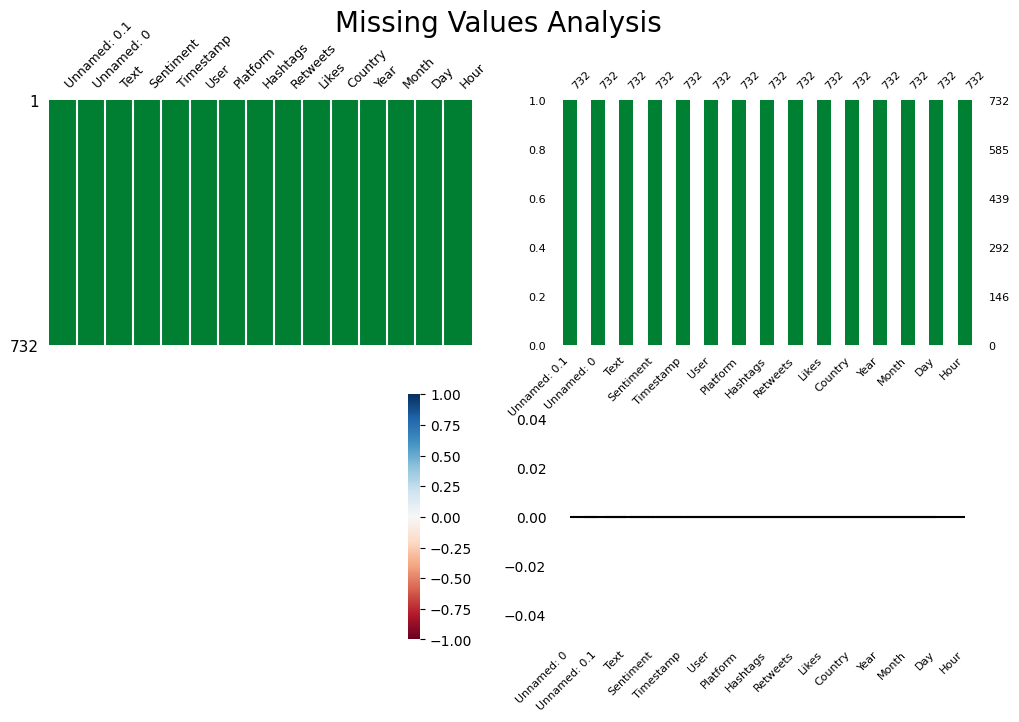

In [ ]:
# @title 1.1 Check The Missing values

import missingno as msno

fig, ax = plt.subplots(2,2,figsize=(12,7))
axs = np.ravel(ax)
msno.matrix(df,  fontsize=9, color=(0.0,0.5,0.2),ax=axs[0]);
msno.bar(df, fontsize=8, color=(0.0,0.5,0.2), ax=axs[1]);
msno.heatmap(df,fontsize=8,ax=axs[2]);
msno.dendrogram(df,fontsize=8,ax=axs[3], orientation='top')

fig.suptitle('Missing Values Analysis', y=1.01, fontsize=20)

plt.savefig('missing_values_analysis.png')

# Show the plot
plt.show()

In [ ]:
# @title 2.Data Cleaning
def clean_Text(Text):
    """
    Cleans the input text by removing special characters, URLs, and converting to lowercase.
    """
    if isinstance(Text, str):
        Text= re.sub(r'http\S+|www\S+|@\S+', '', Text, flags=re.MULTILINE)
        Text = re.sub(r'[^a-zA-Z]', ' ', Text)
        Text = Text.lower()
        return Text
    else:
        return ""
df['cleaned_Text'] = df['Text'].apply(clean_Text)
print(df[['Text', 'cleaned_Text']].head())

def preprocess_Text(Text):
    """
    Tokenizes, removes stopwords, and lemmatizes the input text.
    """
    words = Text.split()
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]
    return ' '.join(words)

df['processed_Text'] = df['cleaned_Text'].apply(preprocess_Text)
print(df[['cleaned_Text', 'processed_Text']].head())


                                                Text  \
0   Enjoying a beautiful day at the park!        ...   
1   Traffic was terrible this morning.           ...   
2   Just finished an amazing workout! 💪          ...   
3   Excited about the upcoming weekend getaway!  ...   
4   Trying out a new recipe for dinner tonight.  ...   

                                        cleaned_Text  
0   enjoying a beautiful day at the park         ...  
1   traffic was terrible this morning            ...  
2   just finished an amazing workout             ...  
3   excited about the upcoming weekend getaway   ...  
4   trying out a new recipe for dinner tonight   ...  
                                        cleaned_Text  \
0   enjoying a beautiful day at the park         ...   
1   traffic was terrible this morning            ...   
2   just finished an amazing workout             ...   
3   excited about the upcoming weekend getaway   ...   
4   trying out a new recipe for dinner tonight   ... 

In [ ]:
# @title 2.1 Handle Missing Values

print("Missing values before handling:")
df.isnull().sum()

Missing values before handling:


,0
Unnamed: 0.1,0
Unnamed: 0,0
Text,0
Sentiment,0
Timestamp,0
User,0
Platform,0
Hashtags,0
Retweets,0
Likes,0


In [ ]:
df['Text'] = df['Text'].fillna('')
df['processed_Text'] = df['processed_Text'].fillna('')
print("\nMissing values after handling:")
df.isnull().sum()


Missing values after handling:


,0
Unnamed: 0.1,0
Unnamed: 0,0
Text,0
Sentiment,0
Timestamp,0
User,0
Platform,0
Hashtags,0
Retweets,0
Likes,0



Sentiment Distribution:
 Sentiment
Positive               44
Joy                    42
Excitement             32
Happy                  14
Neutral                14
                       ..
Vibrancy                1
Culinary Adventure      1
Mesmerizing             1
Thrilling Journey       1
Winter Magic            1
Name: count, Length: 279, dtype: int64


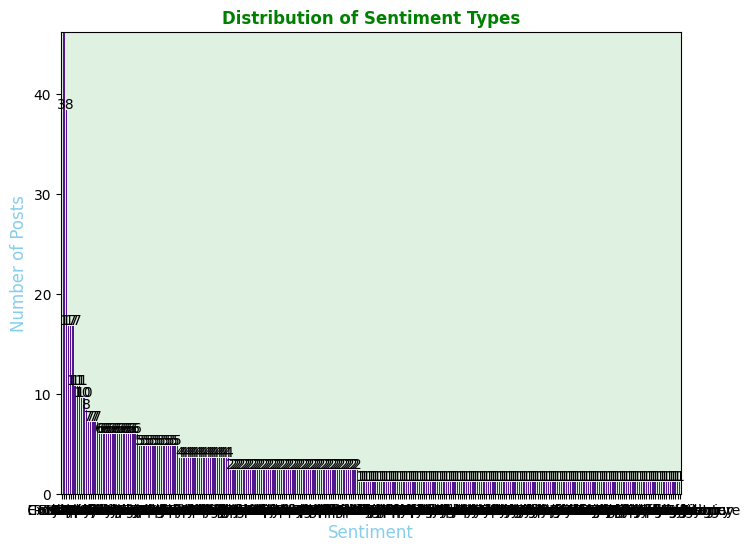

In [ ]:
# @title 3.Exploratory Data Analysis(EDA) 3.1 Sentiment Distribution
sentiment_counts = df['Sentiment'].value_counts()
print("\nSentiment Distribution:\n", sentiment_counts)
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Sentiment Types', fontsize = 12, fontweight = 'bold', color = 'green')
plt.xlabel('Sentiment',fontsize = 12, fontweight = 'normal', color = 'skyblue')
plt.ylabel('Number of Posts',fontsize = 12, fontweight = 'normal', color = 'skyblue')
plt.gca().set_facecolor('#dff2e1')

for p in ax.patches:
    p.set_width(0.6)
    p.set_height(p.get_height()*1.2)
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset pixels')

plt.show()

Sentiment Distribution by Platform:
 Sentiment   Acceptance     Acceptance        Accomplishment   Admiration   \
Platform                                                                    
Facebook                2                 2                3            0   
Instagram               0                 2                0            1   
Twitter                 0                 0                0            0   
Twitter                 1                 1                0            0   

Sentiment   Admiration     Admiration      Adoration      Adrenaline       \
Platform                                                                    
Facebook                0               0              0                1   
Instagram               0               1              0                0   
Twitter                 0               0              0                0   
Twitter                 2               0              2                0   

Sentiment   Adventure   Affection    

<Figure size 1200x600 with 0 Axes>

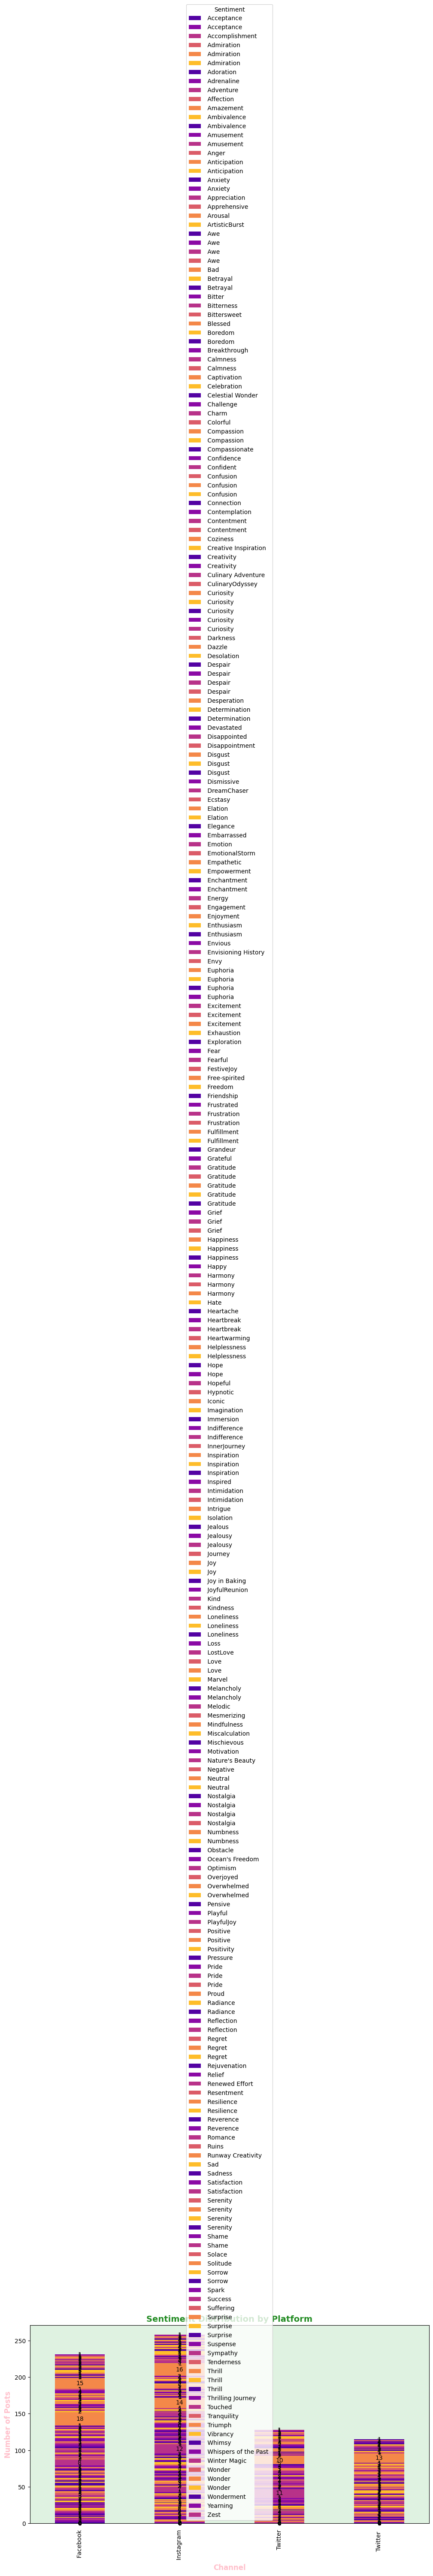

In [ ]:
# @title 3.2 Sentiment Distribution By Platform

channel_sentiment = df.groupby('Platform')['Sentiment'].value_counts().unstack(fill_value=0)
print("Sentiment Distribution by Platform:\n", channel_sentiment)
plt.figure(figsize=(12, 6))
ax = channel_sentiment.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Sentiment Distribution by Platform', fontsize = 14, fontweight = 'bold', color = 'forestgreen')
plt.xlabel('Channel',fontsize = 12, fontweight = 'bold', color = 'pink')
plt.ylabel('Number of Posts',fontsize = 12, fontweight = 'bold', color = 'pink')
plt.legend(title='Sentiment')
plt.gca().set_facecolor('#dff2e1')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.0f}', (x + width/2, y + height/2),
                ha='center', va='center', xytext=(0, 0), textcoords='offset points', color='black')

plt.show()

In [ ]:
# @title 4.Feature Engineering

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['processed_Text'])
y = df['Sentiment']

In [ ]:
# @title 4.1 Split The Data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# @title 5.Model Building
model = MultinomialNB()

In [ ]:
model.fit(X_train, y_train)

MultinomialNB()

Accuracy: 0.1088
                        precision    recall  f1-score   support

         Acceptance          0.00      0.00      0.00         2
           Admiration        0.00      0.00      0.00         1
        Admiration           0.00      0.00      0.00         1
         Affection           0.00      0.00      0.00         1
      Ambivalence            0.00      0.00      0.00         1
         Anger               0.00      0.00      0.00         1
        Anticipation         0.00      0.00      0.00         1
        Arousal              0.00      0.00      0.00         3
                  Awe        0.00      0.00      0.00         1
         Awe                 0.00      0.00      0.00         1
                  Bad        0.00      0.00      0.00         1
             Betrayal        0.00      0.00      0.00         2
        Betrayal             0.00      0.00      0.00         1
         Bitter              0.00      0.00      0.00         1
           Bitterness 

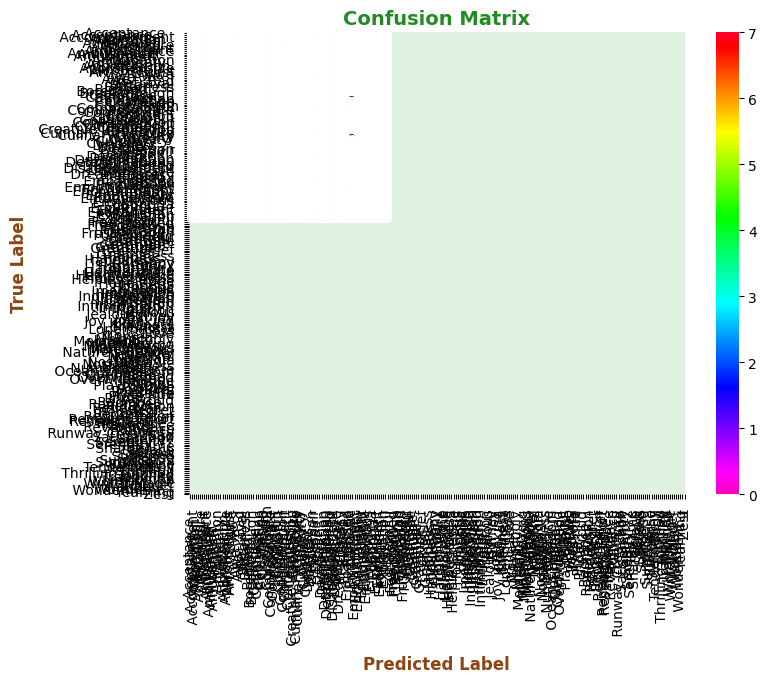

In [ ]:
# @title 6.Evaluate The Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model_nb.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='gist_rainbow_r',
            xticklabels=model_nb.classes_, yticklabels=model_nb.classes_)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold', color='forestgreen')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold', color='saddlebrown')
plt.ylabel('True Label', fontsize=12, fontweight='bold', color='saddlebrown')
plt.gca().set_facecolor('#dff2e1')
plt.show()

In [ ]:
# @title 7.Visualization
# @title
def generate_word_cloud(text):
    """
    Generates and displays a word cloud from the given text.
    """
    if not text:
        print("No text available to generate word cloud.")
        return None

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Social Media Posts', fontsize = 14, fontweight = 'bold', color = 'forestgreen')
    plt.gca().set_facecolor('#dff2e1')
    plt.show()
    return True # return True if wordcloud is generated

Filtered Positive Rows: 45
     Sentiment                         processed_Text
0   Positive              enjoying beautiful day park
2   Positive                 finished amazing workout
3   Positive         excited upcoming weekend getaway
5   Positive       feeling grateful little thing life
6   Positive    rainy day call cozy blanket hot cocoa


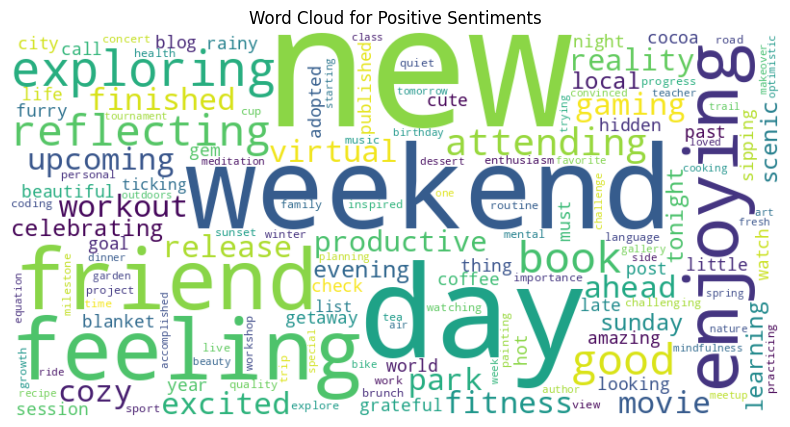

Positive Word Cloud Generated


In [ ]:
# @title 7.1 positive
positive_df = df[df['Sentiment'].str.strip().str.lower() == 'positive']
print("Filtered Positive Rows:", positive_df.shape[0])
print(positive_df[['Sentiment', 'processed_Text']].head())

# Convert to list
Positive_text = positive_df['processed_Text'].dropna().tolist()
Positive_text = [text for text in Positive_text if text.strip() != '']

if Positive_text:
    text = ' '.join(Positive_text)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.title('Word Cloud for Positive Sentiments')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    print("Positive Word Cloud Generated")
else:
    print("No positive sentiment data available.")

Filtered Negative Rows: 4
      Sentiment                         processed_Text
1    Negative                 traffic terrible morning
8    Negative    political discussion heating timeline
11   Negative                feeling bit weather today
19   Negative              winter blue got feeling low


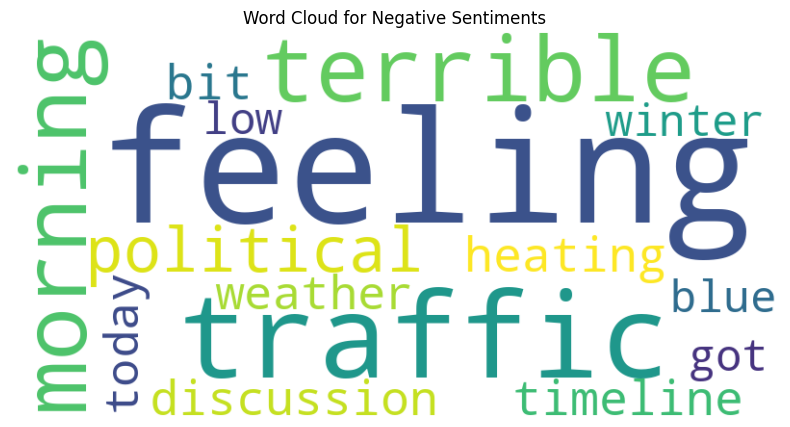

Negative Word Cloud Generated


In [ ]:
# @title 7.2 Negative

negative_df = df[df['Sentiment'].str.strip().str.lower() == 'negative']
print("Filtered Negative Rows:", negative_df.shape[0])
print(negative_df[['Sentiment', 'processed_Text']].head())

# Convert to list
Negative_text = negative_df['processed_Text'].dropna().tolist()
Negative_text = [text for text in Negative_text if text.strip() != '']

if Negative_text:
    text = ' '.join(Negative_text)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.title('Word Cloud for Negative Sentiments')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    print("Negative Word Cloud Generated")
else:
    print("No negative sentiment data available.")




Average Likes per Sentiment:
 Sentiment
Acceptance          35.000000
Acceptance          33.600000
Accomplishment      51.666667
Admiration          45.000000
Admiration          40.000000
                      ...    
Wonder              80.000000
Wonder              80.000000
Wonderment          70.000000
Yearning            20.000000
Zest                31.000000
Name: Likes, Length: 279, dtype: float64


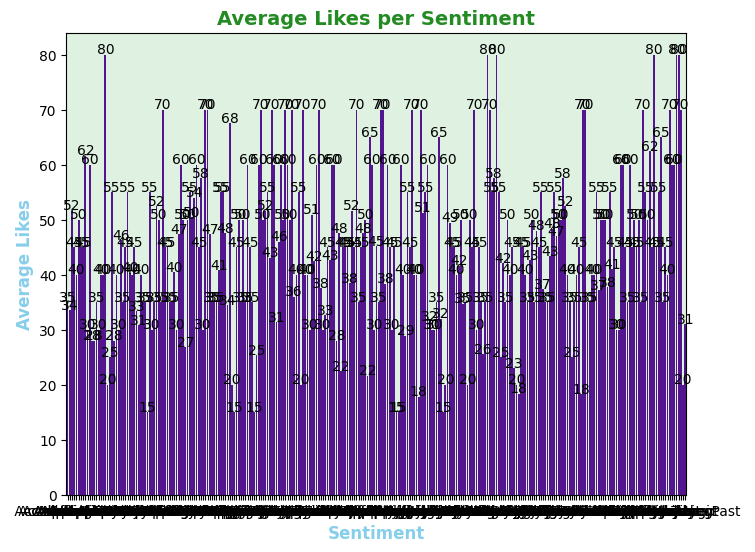

In [ ]:
# @title 7.3 Average Likes Per Sentiment
avg_Likes_sentiment = df.groupby('Sentiment')['Likes'].mean()
print("\nAverage Likes per Sentiment:\n", avg_Likes_sentiment)

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=avg_Likes_sentiment.index, y=avg_Likes_sentiment.values)
plt.title('Average Likes per Sentiment', fontsize = 14, fontweight = 'bold', color = 'forestgreen')
plt.xlabel('Sentiment',fontsize = 12, fontweight = 'bold', color = 'skyblue')
plt.ylabel('Average Likes',fontsize = 12, fontweight = 'bold', color = 'skyblue')
plt.gca().set_facecolor('#dff2e1')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset pixels')

plt.show()

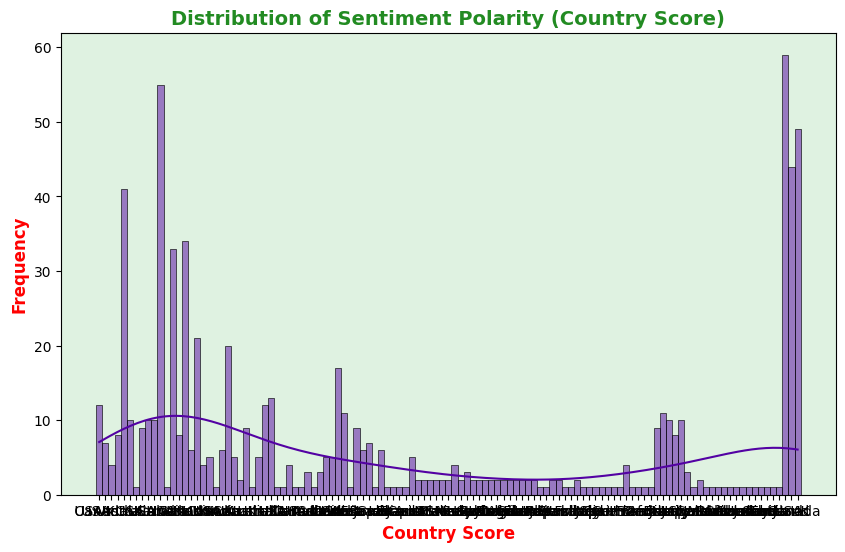

In [ ]:
# @title 7.4 Sentiment polarity
plt.figure(figsize=(10, 6))
sns.histplot(df['Country'], bins=30, kde=True)
plt.title('Distribution of Sentiment Polarity (Country Score)', fontsize = 14, fontweight = 'bold', color = 'forestgreen')
plt.xlabel('Country Score',fontsize = 12, fontweight = 'bold', color = 'red')
plt.ylabel('Frequency',fontsize = 12, fontweight = 'bold', color = 'red')
plt.gca().set_facecolor('#dff2e1')
plt.show()

Text Length Summary:
 count    732.000000
mean       8.132514
std        2.939924
min        3.000000
25%        6.000000
50%        8.000000
75%       10.000000
max       16.000000
Name: processed_Text, dtype: float64


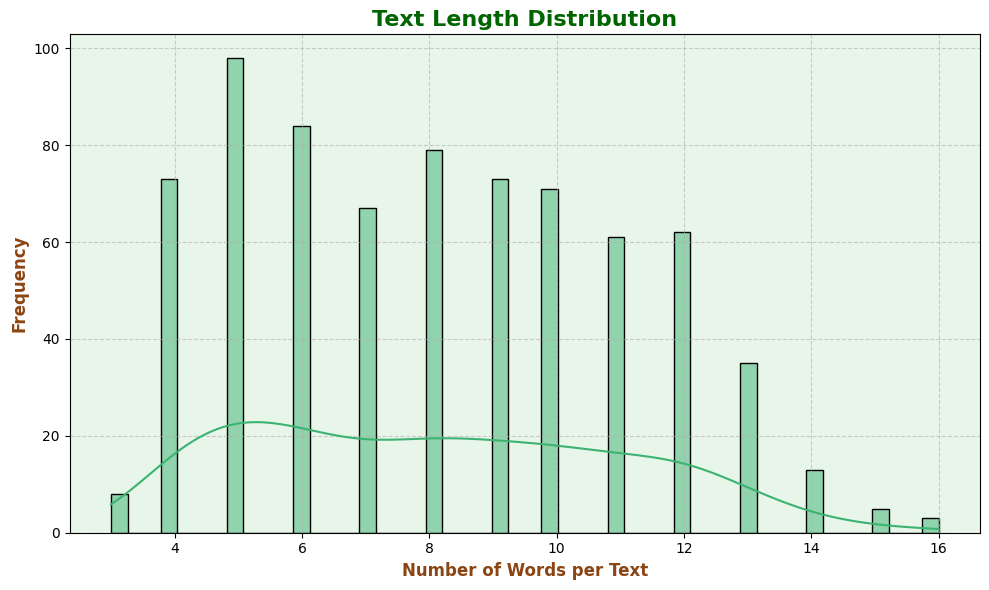

In [ ]:
# @title 7.5 Text Length

# Calculate text length in words
text_length = df['processed_Text'].dropna().apply(lambda x: len(str(x).split()))

print("Text Length Summary:\n", text_length.describe())

plt.figure(figsize=(10, 6))
sns.histplot(text_length, bins=50, kde=True, color='mediumseagreen', edgecolor='black')

plt.title('Text Length Distribution', fontsize=16, fontweight='bold', color='darkgreen')
plt.xlabel('Number of Words per Text', fontsize=12, fontweight='bold', color='saddlebrown')
plt.ylabel('Frequency', fontsize=12, fontweight='bold', color='saddlebrown')

plt.gca().set_facecolor('#e8f5e9')
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# @title 8.Deployment
import joblib
import pickle
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_Text'], df['Sentiment'], test_size=0.2, random_state=42)
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
model_nb = MultinomialNB()
model_nb.fit(X_train_tfidf, y_train)
joblib.dump(model_nb, 'best_model_nb.joblib')
joblib.dump(tfidf, 'best_tfidf.joblib')

print("Model and TF-IDF vectorizer saved successfully.")
try:
    loaded_model = joblib.load('best_model_nb.joblib')
    loaded_vectorizer = joblib.load('best_tfidf.joblib')
    print("Model and vectorizer loaded successfully.")
    new_text = ["Absolutely fantastic experience — exceeded my expectations!"]
    new_text_vectorized = loaded_vectorizer.transform(new_text)
    prediction = loaded_model.predict(new_text_vectorized)
    print(f"Predicted sentiment: {prediction[0]}")

except Exception as e:
    print(f"Error loading model/vectorizer: {e}")


Model and TF-IDF vectorizer saved successfully.
Model and vectorizer loaded successfully.
Predicted sentiment:  Positive  
